In [1]:
import os
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.rec.reconstruction as rec
import algotom
import algotom.prep.calculation as calc
import h5py as h5f
import timeit
import multiprocessing as mp
from joblib import Parallel, delayed
from skimage.measure import profile_line
import ast

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
ncore = mp.cpu_count()
ncore

48

In [3]:
# %matplotlib notebook
%matplotlib inline

# Workflow starts here!

In [14]:
###################### need to change start
ipts="25696"
###################### need to change end

In [15]:
# hdf5_loc = "/netdisk/y9z/IPTS-"+ipts+"/"
hdf5_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
os.listdir(hdf5_loc)

['2021_07_06_1st_discharge_CT_BH_corr.h5',
 '2021_07_05_BH_corr.h5',
 '2021_07_06_1st_discharge_CT.h5',
 '2021_07_05.h5']

In [38]:
###################### need to change start
sample_name = "2021_07_05"
hdf5 = hdf5_loc + sample_name + ".h5"
###################### need to change end

# Load hdf5 file

In [39]:
losa.get_hdf_tree(hdf5)

 tomo
    │
    ├── info
    │   │
    │   ├── ang_deg (1162,)
    │   ├── ang_rad (1162,)
    │   ├── fname (1162,)
    │   ├── proj000_idx (1,)
    │   └── proj180_idx (1,)
    ├── proj
    │   │
    │   ├── dc_fake (240, 950)
    │   ├── ob_fake (240, 950)
    │   ├── proj_mlog_to_recon (1162, 70, 950)
    │   └── proj_norm (1162, 240, 950)
    ├── raw_ref
    │   │
    │   ├── dc_max (2048, 2048)
    │   ├── ob_min (2048, 2048)
    │   ├── proj_crop_roi_min (240, 950)
    │   └── proj_min (2048, 2048)
    ├── recon
    │   │
    │   ├── history (1,)
    │   ├── recon_unit (1,)
    │   └── recon_volume (70, 370, 370)
    └── sino
        │
        ├── sino_mlog (240, 1162, 950)
        └── sino_mlog_to_recon (70, 1162, 950)


deque([' tomo',
       '    │',
       '    ├── info',
       '    │   │',
       '    │   ├── ang_deg (1162,)',
       '    │   ├── ang_rad (1162,)',
       '    │   ├── fname (1162,)',
       '    │   ├── proj000_idx (1,)',
       '    │   └── proj180_idx (1,)',
       '    ├── proj',
       '    │   │',
       '    │   ├── dc_fake (240, 950)',
       '    │   ├── ob_fake (240, 950)',
       '    │   ├── proj_mlog_to_recon (1162, 70, 950)',
       '    │   └── proj_norm (1162, 240, 950)',
       '    ├── raw_ref',
       '    │   │',
       '    │   ├── dc_max (2048, 2048)',
       '    │   ├── ob_min (2048, 2048)',
       '    │   ├── proj_crop_roi_min (240, 950)',
       '    │   └── proj_min (2048, 2048)',
       '    ├── recon',
       '    │   │',
       '    │   ├── history (1,)',
       '    │   ├── recon_unit (1,)',
       '    │   └── recon_volume (70, 370, 370)',
       '    └── sino',
       '        │',
       '        ├── sino_mlog (240, 1162, 950)',
       '        └── 

In [41]:
history_dict_str = losa.load_hdf(hdf5, key_path='tomo/recon/history')[0]
history_dict = ast.literal_eval(history_dict_str.decode("utf-8"))
sino_mlog_to_recon = losa.load_hdf(hdf5, key_path='tomo/sino/sino_mlog_to_recon')
proj_mlog_to_recon = losa.load_hdf(hdf5, key_path='tomo/proj/proj_mlog_to_recon')
proj_norm_to_recon = np.exp(np.negative(proj_mlog_to_recon))
ang_rad = losa.load_hdf(hdf5, key_path='tomo/info/ang_rad')
# rot_center = history_dict['rot_center']
rot_center = history_dict['rot_center_360']
if 'recon_crop_roi' in history_dict.keys():
    recon_crop = True
    recon_crop_left = history_dict['recon_crop_roi']['left']
    recon_crop_right = history_dict['recon_crop_roi']['right']
    recon_crop_top = history_dict['recon_crop_roi']['top']
    recon_crop_bottom = history_dict['recon_crop_roi']['bottom']
else:
    recon_crop = False
    recon_crop_left = None
    recon_crop_right = None
    recon_crop_top = None
    recon_crop_bottom = None
history_dict

{'crop': True,
 'crop_roi': {'left': 350, 'right': 1300, 'top': 860, 'bottom': 1100},
 'gamma_filter': True,
 'gamma_diff': 20,
 'normalization': True,
 'minus_log': True,
 'tilt_corr_roi': {'left': 0, 'right': 4000, 'top': 0, 'bottom': 7000},
 'tilt_corr': 0.06240916313038407,
 'rot_center_360': 552.4011764526367,
 'rot_center_180': 538.5,
 'rr_roi_crop': True,
 'rr_roi': {'left': 0, 'right': 4000, 'top': 40, 'bottom': 110},
 'ring_removal': 'bm3d',
 'pixel_size_um': 42.7,
 'recon_algo': 'gridrec',
 'recon_crop': True,
 'recon_crop_roi': {'left': 250, 'right': 620, 'top': 250, 'bottom': 620}}

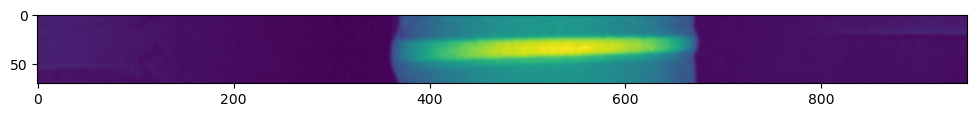

In [42]:
plt.imshow(proj_mlog_to_recon[0])
# plt.colorbar()
plt.show()

/tmp/ipykernel_46597/3587648887.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Time: 0.19546001606698457 mins


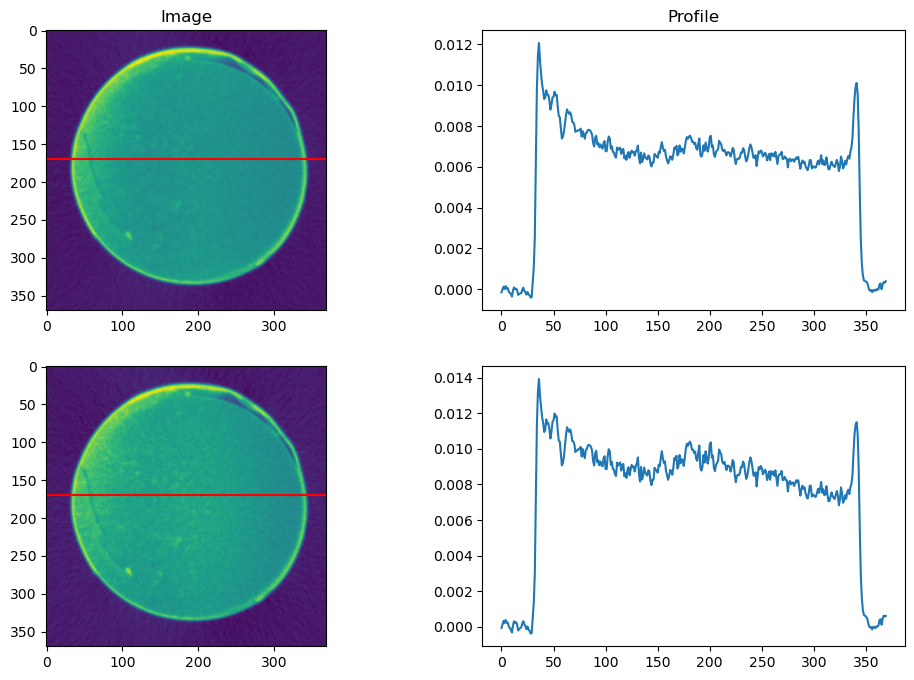

In [43]:
###################### need to change start
idx = 48
line_loc = 170
bh_q = 0.005
bh_n = 15
bh_opt = True
###################### need to change end
t0 = timeit.default_timer()
rec_img = rec.gridrec_reconstruction(sino_mlog_to_recon[idx], rot_center, angles=ang_rad, apply_log=False)
rec_img = rocku.crop(rec_img, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)

proj_norm_to_recon_bh_corr = corr.beam_hardening_correction(mat=proj_norm_to_recon, q=bh_q, n=bh_n, opt=bh_opt)
proj_mlog_to_recon_bh_corr = np.negative(np.log(proj_norm_to_recon_bh_corr))
sino_mlog_to_recon_bh_corr = np.moveaxis(proj_mlog_to_recon_bh_corr, 1, 0)
rec_img_bh_corr = rec.gridrec_reconstruction(sino_mlog_to_recon_bh_corr[idx], rot_center, angles=ang_rad, apply_log=False)
rec_img_bh_corr = rocku.crop(rec_img_bh_corr, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)

start = (line_loc, 0)
end = (line_loc, rec_img.shape[1]-1)
profile = profile_line(rec_img, start, end)
profile_bh_corr = profile_line(rec_img_bh_corr, start, end)
fig, ax = plt.subplots(2, 2)
ax[0][0].set_title('Image')
ax[0][0].imshow(rec_img)
ax[0][0].plot([start[1], end[1]], [start[0], end[0]], 'r')
ax[0][1].set_title('Profile')
ax[0][1].plot(profile)
# ax[1][0].set_title('Image_BH')
ax[1][0].imshow(rec_img_bh_corr)
ax[1][0].plot([start[1], end[1]], [start[0], end[0]], 'r')
# ax[1][1].set_title('Profile_BH')
ax[1][1].plot(profile_bh_corr)
fig.show()
t1 = timeit.default_timer()
print("Time: {} mins".format((t1-t0)/60))

# Reconstruction

In [44]:
pix_um = history_dict['pixel_size_um']
# pix_um = 42.7
pix_cm = pix_um/10000
t0 = timeit.default_timer()
recon_algo = history_dict['recon_algo']
# recon_algo = 'svmbir'
##################################
t0 = timeit.default_timer()
####################### tomopy algorithms (gridrec and fbp are faster than algotom) ##########################
if recon_algo in ['art', 'bart', 'fbp', 'gridrec',
                  'mlem', 'osem', 'ospml_hybrid', 'ospml_quad',
                  'pml_hybrid', 'pml_quad', 'sirt', 'tv', 'grad', 'tikh']:
    recon = tomopy.recon(proj_mlog_to_recon_bh_corr, ang_rad, center=rot_center,
                         algorithm=recon_algo,
                         ncore=ncore, 
#                          nchunk=nchunk
                        )
if pix_um is not None:
    pix_cm = pix_um/10000
    recon = recon/pix_cm
recon = rocku.crop(recon, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)

# for h_idx in range(sino_mlog_to_recon.shape[0]):
#     _sino_mlog_to_recon_bh_corr = corr.beam_hardening_correction(mat=sino_mlog_to_recon[h_idx], q=bh_q, n=bh_n)
#     _rec_slice = rec.gridrec_reconstruction(_sino_mlog_to_recon_bh_corr, rot_center, angles=ang_rad, apply_log=False)
#     _rec_slice = rocku.crop(_rec_slice, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
#     _rec_slice_cm = _rec_slice/pix_cm
#     _slice_name = save_to + "/recon_" + f'{h_idx:04d}'
#     print('Saving {} ...'.format(_slice_name))
#     dxchange.write_tiff(_rec_slice_cm, fname=_slice_name, overwrite=True)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))

Time cost 0.018377646633113424 min


In [45]:
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name + '_BH'
print("Saving to: {}".format(save_to))
dxchange.write_tiff_stack(recon, fname=save_to + "/recon", overwrite=True, digit=4)

Saving to: /HFIR/CG1D/IPTS-25696/shared/processed_data/rockit/2021_07_05_BH


In [46]:
history_dict = rocku.log(history_dict, 'BH_corr', True)
bh_corr_param = {
    'q': bh_q,
    'n': bh_n,
    'opt': bh_opt,
}
history_dict = rocku.log(history_dict, 'BH_corr_param', bh_corr_param)

In [47]:
history_dict

{'crop': True,
 'crop_roi': {'left': 350, 'right': 1300, 'top': 860, 'bottom': 1100},
 'gamma_filter': True,
 'gamma_diff': 20,
 'normalization': True,
 'minus_log': True,
 'tilt_corr_roi': {'left': 0, 'right': 4000, 'top': 0, 'bottom': 7000},
 'tilt_corr': 0.06240916313038407,
 'rot_center_360': 552.4011764526367,
 'rot_center_180': 538.5,
 'rr_roi_crop': True,
 'rr_roi': {'left': 0, 'right': 4000, 'top': 40, 'bottom': 110},
 'ring_removal': 'bm3d',
 'pixel_size_um': 42.7,
 'recon_algo': 'gridrec',
 'recon_crop': True,
 'recon_crop_roi': {'left': 250, 'right': 620, 'top': 250, 'bottom': 620},
 'BH_corr': True,
 'BH_corr_param': {'q': 0.005, 'n': 15, 'opt': True}}

In [48]:
# output_hdf5_dir = "/netdisk/y9z/IPTS-"+ipts+"/hdf5/"
# output_hdf5_dir = "/netdisk/y9z/CG1D/IPTS-"+ipts+"/rockit/hdf5/"
output_hdf5_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
output_hdf5 = output_hdf5_dir + sample_name + "_BH_corr.h5"

In [49]:
with h5f.File(output_hdf5, mode='a') as f:
    f.create_group('tomo/recon')
    f.create_dataset('tomo/recon/recon_volume_BH', data=recon)
    f.create_dataset('tomo/recon/history', data=(str(history_dict),))